In [1]:
import numpy as np
import pandas as pd

In [2]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [3]:
train_data = train_data[:100]
test_data = test_data[:100]

In [4]:
print(train_data.notnull().sum())
print('-'*30)
print(train_data.isnull().sum())

textID           100
text             100
selected_text    100
sentiment        100
dtype: int64
------------------------------
textID           0
text             0
selected_text    0
sentiment        0
dtype: int64


Có một hàng trong tập huấn luyện mà có **text** và **selected_text** bị missing. Loại bỏ nó.

In [5]:
train_data.dropna(axis=0, inplace=True)

In [6]:
# BPE (Byte Pair Encoding) tokenizer is used for tokenizing text

import tokenizers
import numpy as np
max_len = 128
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file = './roberta.base.tf/vocab-roberta-base.json',
    merges_file = './roberta.base.tf/merges-roberta-base.txt',
    lowercase=True,
    add_prefix_space=True
)

sentiment_id = {'positive': tokenizer.encode('positive').ids[0],
                'negative':tokenizer.encode('negative').ids[0], 
                'neutral':tokenizer.encode('neutral').ids[0]}

train_data.reset_index(inplace=True)

In [7]:
sentiment_id

{'positive': 1313, 'negative': 2430, 'neutral': 7974}

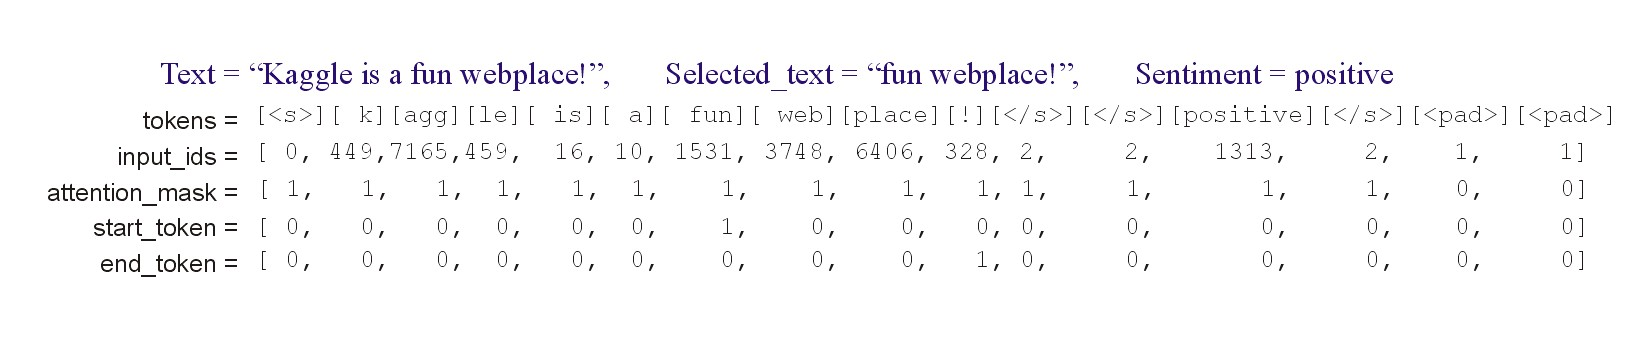

In [8]:
# Định dạng input data cho training

num_samples = train_data.shape[0]

# Các token đầu vào (sub word) dưới dạng số
input_ids = np.ones((num_samples, max_len), dtype='int32')
# 1 là attention, 0 thì không là attention (ví dụ pad)
attention_mask = np.zeros((num_samples, max_len), dtype='int32')

token_type_ids = np.zeros((num_samples, max_len), dtype='int32')

# 1 là vị trí bắt đầu của token selected_text, còn lại là 0
start_tokens = np.zeros((num_samples, max_len), dtype='int32')
# 1 là vị trí kết thúc của token selected_text, còn lại là 0
end_tokens = np.zeros((num_samples, max_len), dtype='int32')

In [9]:
for k in range(num_samples):
  # FIND OVERLAP
  text1 = " "+" ".join(train_data.loc[k,'text'].split())
  text2 = " ".join(train_data.loc[k,'selected_text'].split())
  idx = text1.find(text2)
  chars = np.zeros(len(text1))
  # đánh dấu những ký tự mà bao gồm text2
  chars[idx:idx+len(text2)] = 1
  if text1[idx-1] == ' ':
    chars[idx-1] = 1
  enc = tokenizer.encode(text1)
  # print(enc.ids)

  # ID_OFFSETS
  offsets = []
  idx =0
  for num in enc.ids:
    w = tokenizer.decode([num])
    offsets.append((idx, idx+len(w)))
    idx+=len(w)
  
  # START END TOKENS
  tokens = []
  for i, (a, b) in enumerate(offsets):
    sum = np.sum(chars[a:b])
    if sum>0:
      tokens.append(i)
  
  s_token = sentiment_id[train_data.loc[k,'sentiment']]
  # Cấu hình các định dạng đầu vào
  input_ids[k, :len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_token] + [2]
  attention_mask[k, :len(enc.ids)+5]=1
  if len(tokens)>0:
    start_tokens[k, tokens[0]+1]=1
    end_tokens[k, tokens[-1]+1]=1

# Build model
Chúng ta sử dụng pretrained roBERTa base model và thêm một custom question answer head. Các token đầu là input vào bert_model và chúng ta sử dụng ouput đầu tiên của BERT. Các nhúng của tất cả các token đầu vào và có số chiều là (batch_size, max_len, 768). Tiếp theo chúng ta áp dụng Conv1D(filters=1, kernel_size=1) và chuyển đổi các embedding thànnh số chiều (batch_size, max_len, 1). Chúng ta flaten và áp dụng softmax, vì vậy kết quả cuối cùng x1 có chiều là (batch_size, max_len). Đây là one hot encoding của start token (cho selected_text) và x2 là end_tokens

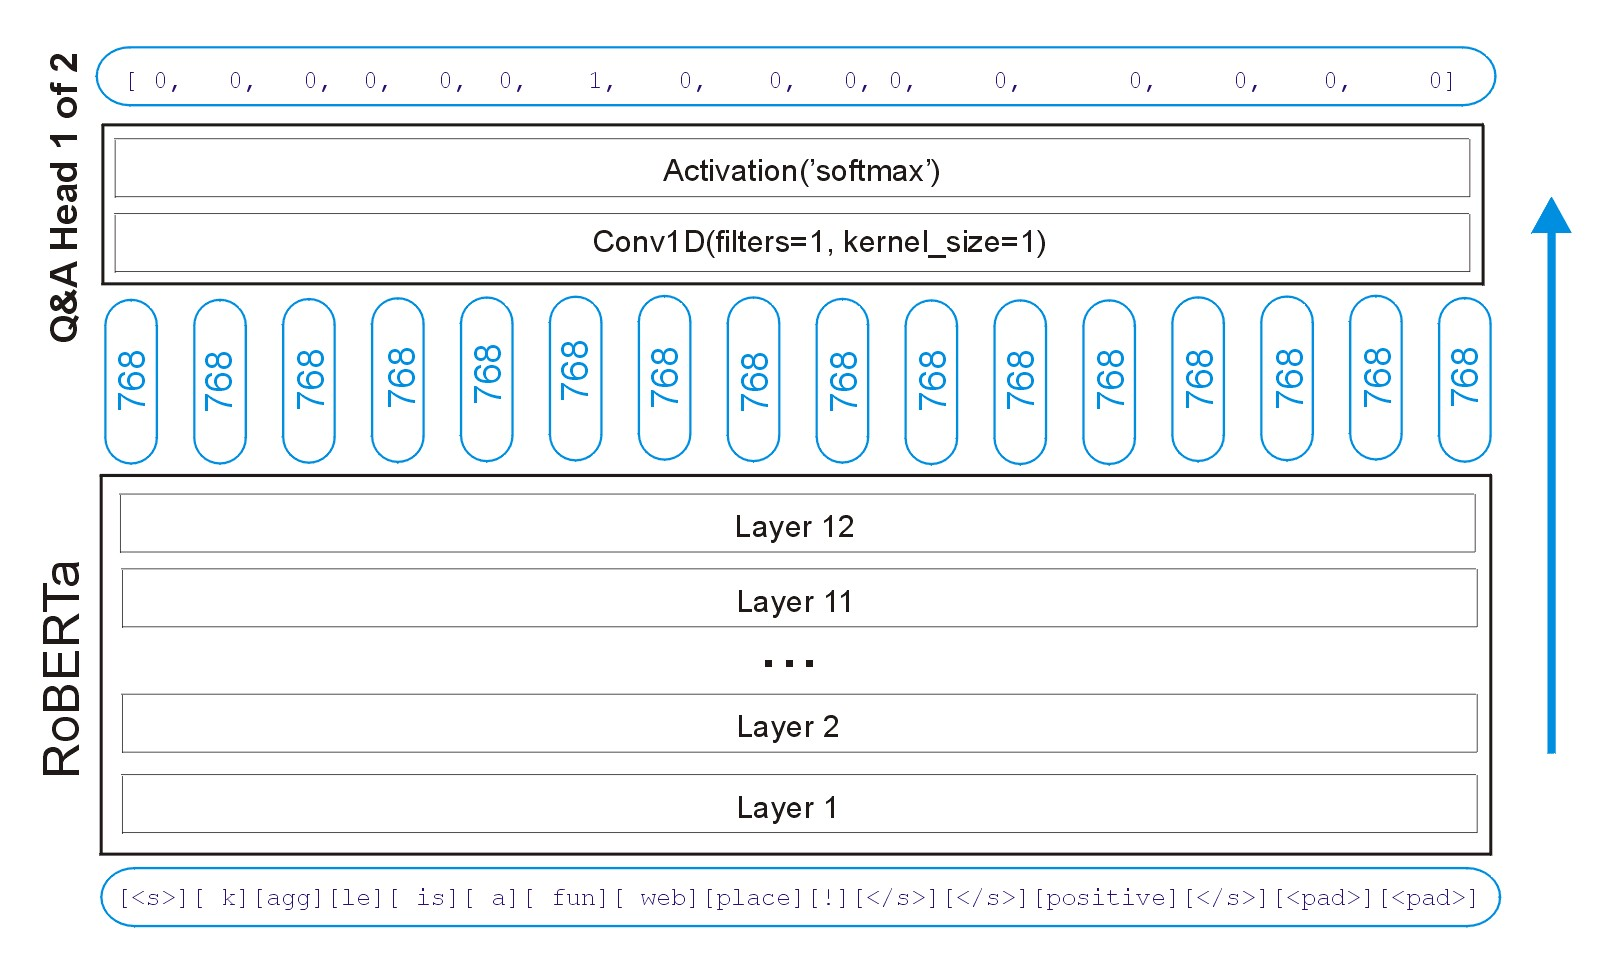


In [10]:
import tensorflow as tf
from transformers import RobertaConfig, TFRobertaModel

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [11]:
def build_model():
    ids = tf.keras.layers.Input((max_len,), dtype=tf.int32)
    att = tf.keras.layers.Input((max_len,), dtype=tf.int32)
    tok = tf.keras.layers.Input((max_len,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained('./roberta.base.tf/config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained('./roberta.base.tf/pretrained-roberta-base.h5', config=config)

    x = bert_model(ids, attention_mask = att, token_type_ids=tok)

    x1 = tf.keras.layers.Dropout(0.1)(x[0])
    x1 = tf.keras.layers.Conv1D(1, 1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)

    x2 = tf.keras.layers.Dropout(0.1)(x[0])
    x2 = tf.keras.layers.Conv1D(1, 1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model

In [12]:
# Metric
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return np.float32(len(c)) / (len(a) + len(b) - len(c))

# Train Roberta model

In [13]:
num_t = test_data.shape[0]
input_ids_t = np.ones((num_t, max_len), dtype='int32')
attention_mask_t = np.zeros((num_t, max_len), dtype='int32')
token_type_ids_t = np.zeros((num_t, max_len), dtype='int32')

for k in range(num_t):
    # INPUT_IDS
    text1 = " " + " ".join(test_data.loc[k, 'text'].split())
    enc = tokenizer.encode(text1)
    s_tok = sentiment_id[test_data.loc[k, 'sentiment']]
    input_ids_t[k, :len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1

In [14]:
from sklearn.model_selection import StratifiedKFold

In [15]:
jac = []
VER = 'v0'
DISPLAY = 1

In [16]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=28091997)

In [17]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [18]:
oof_start = np.zeros((num_samples, max_len))
oof_end = np.zeros((num_samples, max_len))
preds_start = np.zeros((num_t, max_len))
preds_end = np.zeros((num_t, max_len))

for fold , (idxT, idxV) in enumerate(skf.split(input_ids, train_data.sentiment.values)):
    print("##### FOLD {} #####".format(fold+1))
    
    model = build_model()
    checkpoint = tf.keras.callbacks.ModelCheckpoint('./save/%s-roberta-%i.h5'%(VER, fold), monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
    
    print("Start training...")
    
    model.fit([input_ids[idxT, ], attention_mask[idxT,], token_type_ids[idxT,]],
              [start_tokens[idxT,], end_tokens[idxT,]],
              epochs=3, batch_size=1, verbose=1, callbacks=[checkpoint],
              validation_data = ([input_ids[idxV, ], attention_mask[idxV,], token_type_ids[idxV,]], 
                                 [start_tokens[idxV, ], end_tokens[idxV,]])
             )
    
    print("End training...")

    print("Loading model...")
    model.load_weights('./save/%s-roberta-%i.h5'%(VER, fold))

    print("Predicting OOF...")
    oof_start[idxV, ], oof_end[idxV,] = model.predict([input_ids[idxV,], attention_mask[idxV,], token_type_ids[idxV,]], verbose=1)

    print("Predicting Test...")
    preds = model.predict([input_ids_t, attention_mask_t, token_type_ids_t], verbose=1)

    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits

    # Display fold jaccard
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k, ])
        if a>b:
            st = train_data.loc[k, 'text'] # cai thien CV/LB
        else:
            text1 = " " + " ".join(train_data.loc[k, 'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-1:b])
        all.append(jaccard(st, train_data.loc[k, 'selected_text']))
    jac.append(np.mean(all))
    print(">>>> FOLD {} Jaccard = {}".format(fold+1, np.mean(all)))
    print()


##### FOLD 1 #####
All model checkpoint weights were used when initializing TFRobertaModel.

All the weights of TFRobertaModel were initialized from the model checkpoint at ./roberta.base.tf/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
Start training...
Epoch 1/3
66/66 [==============================] - ETA: 0s - loss: 5.7286 - activation_4_loss: 2.5580 - activation_5_loss: 3.1706WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0055s vs `on_test_batch_end` time: 0.0261s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 3.36442, saving model to ./save/v0-roberta-0.h5
66/66 [==============================] - 23s 343ms/step - loss: 5.7286 - activation_4_loss: 2.5580 - activation_5_loss: 3.1706 - val_loss: 3.3644 - val_activation_4_loss: 1.4574 - val_activation_5_loss: 1.9070
Ep

ResourceExhaustedError: in user code:

    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:757 train_step
        self.trainable_variables)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:2745 _minimize
        experimental_aggregate_gradients=False)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:519 apply_gradients
        self._create_all_weights(var_list)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:704 _create_all_weights
        self._create_slots(var_list)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/adam.py:129 _create_slots
        self.add_slot(var, 'v')
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:764 add_slot
        initial_value=initial_value)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:262 __call__
        return cls._variable_v2_call(*args, **kwargs)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:256 _variable_v2_call
        shape=shape)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2857 creator
        return next_creator(**kwargs)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2857 creator
        return next_creator(**kwargs)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2857 creator
        return next_creator(**kwargs)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py:685 variable_capturing_scope
        lifted_initializer_graph=lifted_initializer_graph, **kwds)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:264 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py:226 __init__
        initial_value() if init_from_fn else initial_value,
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/keras/initializers/initializers_v2.py:137 __call__
        return super(Zeros, self).__call__(shape, dtype=_get_dtype(dtype))
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops_v2.py:132 __call__
        return array_ops.zeros(shape, dtype)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py:2747 wrapped
        tensor = fun(*args, **kwargs)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py:2806 zeros
        output = fill(shape, constant(zero, dtype=dtype), name=name)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py:239 fill
        result = gen_array_ops.fill(dims, value, name=name)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py:3402 fill
        _ops.raise_from_not_ok_status(e, name)
    /home/thang/env/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:6843 raise_from_not_ok_status
        six.raise_from(core._status_to_exception(e.code, message), None)
    <string>:3 raise_from
        

    ResourceExhaustedError: OOM when allocating tensor with shape[768,3072] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]


In [ ]:
print('>>>> OVERALL 5Fold CV Jaccard =',np.mean(jac))

In [ ]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test_data.loc[k,'text']
    else:
        text1 = " "+" ".join(test_data.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    all.append(st)

In [ ]:
test_data['selected_text'] = all
test_data[['textID','selected_text']].to_csv('./submission/submission.csv',index=False)
pd.set_option('max_colwidth', 60)
test_data.sample(25)